# Data Acquisition (ETL) - test

**Starting Point:**  
The article data originates from a Kafka datastream. It is not normalized (so it cannot be analyzed directly) and requires Active Directory login (making collaboration difficult).  
- [View Kafka topic data (AKHQ)](https://akhq.pdp.production.admin.srgssr.ch/ui/strimzi/topic/articles-v2/data?sort=NEWEST&partition=All)

- **Processing steps:**  
  1. Read article data from the Delta table populated from Kafka.
  2. Flatten and transform nested fields (e.g., titles, resources, contributors) using a SQL view.
  3. Create a Spark DataFrame from the flattened view and inspect the results.
  4. Write the DataFrame to a Delta table for analytics and automation.
  5. Export a <25MB Parquet sample with only public data for sharing (e.g., via GitHub).

**Goal:**  
The data should be available as a Parquet file for sharing. Since the dataset is large (5GB), only a public sample is exported for easy distribution.

**Access Control:**  
To guarantee data integrity and protect sensitive information, data distribution is based on user access rights. Entitled users can access the full confidential dataset, while restricted users are provided with only the public sample. This ensures that only authorized users can view sensitive data, maintaining compliance and data security.

## Step-01: Read from Kafka (SQL)

The following steps read article data from the Delta table `udp_prd_atomic.pdp.articles_v2`, which is assumed to be populated from a Kafka stream. The original Kafka data contains nested lists and complex structures (e.g., for multilingual fields or arrays of resources). In the transformation, the SQL view `articles_flat` flattens this nested data by extracting relevant fields and, where multiple values exist (such as for titles in different languages), selects the first available entry—typically prioritizing German (`'de'`) or otherwise the first value. This process prepares the data, along with Kafka metadata (key, topic, partition, offset, timestamp), for further analysis in a flat, tabular format.

## Step-02: Create DataFrame and Visually Inspect Results

The code below runs a Spark SQL query against the temporary view `articles_flat`, loads the result into a Spark DataFrame named `df`, and then displays the DataFrame for visual inspection. This step materializes the flattened article data so it can be further processed or written to a Delta table.

## Step-03: Save Data to Delta Table

In the next steps, the data will be saved both to a Delta table (for better automation and analytics).

### Write to (private) Delta Table - all articles

The following code appends the transformed DataFrame `df` to the Delta table `swi_audience_prd.pdp_articles_v2.articles_v2`. It writes in **append** mode, uses the **Delta** format, and enables **schema merging** so that any new columns are automatically added to the target table without overwriting existing data.

- Contains all articles (**confidential**)


### Write to (public) Parquet File - selected articles, manually Upload to GitHub

Export a <25 MB sample of the data with only public data as a Parquet file for easy sharing via GitHub.  
**Note:** The Parquet file must be manually downloaded from Databricks and then uploaded to your GitHub repository.

...now manually:

1. **Open the CSV file in Databricks:**
   - Navigate to [Databricks Volume Browser](https://adb-4119964566130471.11.azuredatabricks.net/explore/data/volumes/swi_audience_prd/pdp_articles_v2/pdp_articles_v2_volume?o=4119964566130471) in the Databricks workspace file browser.

2. **Download the file:**
   - Right-click on `export_articles_v2_sample25mb.parquet` and select **"Download"** to save the file to your local machine.

3. **Upload the file to GitHub:**
   - Go to [GitHub Folder](https://github.com/Tao-Pi/CAS-Applied-Data-Science/tree/main/Module-3/01_Module%20Final%20Assignment).
   - Click **"Add file"** > **"Upload files"**.
   - Drag and drop `export_articles_v2_sample25mb.parquet` or use the file picker to select it.
   - Commit the changes to upload the file.


## Step-04: Load Data Based on User Rights

The next step is to load the data, with access determined by user rights:

- **Restricted users** can load only the public data sample (e.g., the Parquet file exported for sharing).
- **Entitled users** can load the full, confidential dataset from the Delta table.

This ensures that sensitive information is only accessible to authorized users, while still allowing broader access to public data for collaboration and analysis.

In [1]:
%pip install pandas
%pip install pyarrow
%pip install fastparquet
#%pip install -U sentence-transformers torch safetensors accelerate


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 45.6 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 14.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fastparquet]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
url = "https://github.com/Tao-Pi/CAS-Applied-Data-Science/raw/main/Module-3/01_Module%20Final%20Assignment/export_articles_v2_sample25mb.parquet"
srgssr_article_corpus = pd.read_parquet(url, engine="fastparquet")

In [3]:
has_read_access_udp_articles_v2 = False

# Dataset Overview

In this chapter, we provide a brief overview of the dataset used for analysis. We indicate whether the loaded dataset is the full confidential version or the public sample, report the total number of articles available, and present a first look at the articles data to understand its structure and content.


## Step 1: Check Dataset Version (Confidential vs Public)

Here we check and indicate whether the loaded dataset is the full confidential version or the public sample.

In [4]:
def format_rowcount(n):
    if n >= 1_000_000:
        return f"more than {n // 1_000_000} million"
    elif n >= 1_000:
        return f"more than {n // 1_000} thousand"
        return f"more than {n // 1_000_000} Mio."
    elif n >= 1_000:
        return f"more than {n // 1_000} Tsd."
    else:
        return f"{n}"

if has_read_access_udp_articles_v2:
    rowcount = srgssr_article_corpus.count()
    print(f"congrats: you have successfully read the full data set. This contains the full corpus of {format_rowcount(rowcount)} Articles published by SRG-SSR as plain text together with some relevant metadata. You can access the dataframe object by calling 'srgssr_article_corpus' from Python now.")
else:
    if isinstance(srgssr_article_corpus, pd.DataFrame):
        rowcount = len(srgssr_article_corpus)
    else:
        rowcount = srgssr_article_corpus.count()
    print(f"congrats: you have successfully read the publically available (sampled) data set. This contains an excerpt of {format_rowcount(rowcount)} articles within SRG-SSR as plain text together with some relevant metadata. You can access the dataframe object by calling 'srgssr_article_corpus' from Python now.")

congrats: you have successfully read the publically available (sampled) data set. This contains an excerpt of more than 11 thousand articles within SRG-SSR as plain text together with some relevant metadata. You can access the dataframe object by calling 'srgssr_article_corpus' from Python now.



## Step 2: Overview of the Data

In this step, we provide an overview of the data contained in the loaded dataset. This includes a summary of the available articles and a first look at their structure and content.

In [5]:
# Falls DataFrame leer ist → leeres dict
first_row = srgssr_article_corpus.iloc[0].to_dict() if not srgssr_article_corpus.empty else {}

cols_info = [
    {
        "column": col,
        "type": str(dtype),
        "example": first_row.get(col, None)
    }
    for col, dtype in srgssr_article_corpus.dtypes.items()
]

# Schön anzeigen
import pandas as pd
pd.DataFrame(cols_info).head(20)


,column,type,example
0,id,object,urn:pdp:cue_rsi:article:rsi:cue:story:3238385
1,publisher,object,RSI
2,provenance,object,CUE_RSI
3,modificationDate,datetime64[ns],2025-11-17 15:48:25
4,releaseDate,datetime64[ns],2025-10-29 15:48:31
5,title_auto,object,L’amore oltre le sbarre
6,lead_auto,object,Veronica Barbato fotografa la vita tormentata ...
7,kicker_auto,object,Fotografia e carceri
8,id_urn,object,None
9,id_srg,object,None


## Step 3: A Closer Look

In this step, we take a deeper look at the loaded dataset, exploring its structure and content in more detail.

In [6]:
display(srgssr_article_corpus)

,id,publisher,provenance,modificationDate,releaseDate,title_auto,lead_auto,kicker_auto,id_urn,id_srg,picture_url,content_text_csv,contributors_csv,resources_locator_urls_csv,keywords_csv,key,topic,partition,offset,timestamp
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,RSI,CUE_RSI,2025-11-17 15:48:25.000,2025-10-29 15:48:31,L’amore oltre le sbarre,Veronica Barbato fotografa la vita tormentata ...,Fotografia e carceri,None,None,None,“Buonanotte” era una trasmissione di una radio...,Author,https://www.rsi.ch/s/3238385,CULTURA,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,articles-v2,6,897052,2025-10-29 15:55:20.290
1,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,RSI,CUE_RSI,2025-10-31 08:00:00.000,2025-10-30 20:32:57,“Dietro le quinte tanto lavoro per strutturars...,"In attesa della licenza, l’ACB chiude all’FCL ...",Calcio Svizzero,None,None,https://il.rsi.ch/rsi-api/resize/image/v2//WEB...,Sono giorni decisamente importanti per il Bell...,Author,https://www.rsi.ch/s/3242447,SPORT,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,articles-v2,3,902310,2025-10-30 20:34:41.815
2,urn:pdp:cms_swi:article:90255795,SWI,CMS_SWI,2025-10-31 00:01:11.708,2025-10-30 23:56:45,EUA reduzirá bruscamente admissão de refugiado...,None,None,None,None,https://www.swissinfo.ch/content/wp-content/up...,EUA reduzirá bruscamente admissão de refugiado...,None,https://www.swissinfo.ch/por/eua-reduzir%c3%a1...,"Política,Sociedade,sociedade (geral)",urn:pdp:cms_swi:article:90255795,articles-v2,2,909146,2025-10-31 00:01:14.422
3,urn:pdp:cms_swi:article:90255781,SWI,CMS_SWI,2025-10-30 23:56:11.323,2025-10-30 23:50:50,República Dominicana se solidariza con el pres...,None,None,None,None,None,República Dominicana se solidariza con el pres...,None,https://www.swissinfo.ch/spa/rep%c3%bablica-do...,"Política,tratados y organizaciones,democracia",urn:pdp:cms_swi:article:90255781,articles-v2,5,906285,2025-10-30 23:56:13.949
4,urn:pdp:cms_swi:article:90255780,SWI,CMS_SWI,2025-10-30 23:51:12.935,2025-10-30 23:49:07,La española Telefónica se despide de Ecuador t...,None,None,None,None,None,La española Telefónica se despide de Ecuador t...,None,https://www.swissinfo.ch/spa/la-espa%c3%b1ola-...,"servicio de telecomunicaciones,empresas",urn:pdp:cms_swi:article:90255780,articles-v2,6,897411,2025-10-30 23:51:15.547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11065,urn:pdp:cms_swi:article:90204318,SWI,CMS_SWI,2025-10-21 21:31:05.000,2025-10-21 21:27:11,Dow Jones cierra al alza con nuevo récord apoy...,None,None,None,None,None,Dow Jones cierra al alza con nuevo récord apoy...,None,https://www.swissinfo.ch/spa/dow-jones-cierra-...,valores,urn:pdp:cms_swi:article:90204318,articles-v2,0,897977,2025-10-21 21:31:07.468
11066,urn:pdp:cms_swi:article:90204319,SWI,CMS_SWI,2025-10-21 21:31:03.932,2025-10-21 21:29:15,Condenan en Colombia a 21 años de prisión a ot...,None,None,None,None,None,Condenan en Colombia a 21 años de prisión a ot...,None,https://www.swissinfo.ch/spa/condenan-en-colom...,"criminalidad,administración de corte,investiga...",urn:pdp:cms_swi:article:90204319,articles-v2,2,906813,2025-10-21 21:31:06.370
11067,urn:pdp:cms_swi:article:90204316,SWI,CMS_SWI,2025-10-21 21:26:09.636,2025-10-21 21:20:17,Costa Rica celebra la elección de la primera m...,None,None,None,None,None,Costa Rica celebra la elección de la primera m...,None,https://www.swissinfo.ch/spa/costa-rica-celebr...,gobierno,urn:pdp:cms_swi:article:90204316,articles-v2,7,900307,2025-10-21 21:26:12.101
11068,urn:pdp:cms_swi:article:90204317,SWI,CMS_SWI,2025-10-21 21:26:07.003,2025-10-21 21:20:56,Netflix aumentó su beneficio neto en un 25 % e...,None,None,None,None,None,Netflix aumentó su beneficio neto en un 25 % e...,None,https://www.swissinfo.ch/spa/netflix-aument%c3...,"internet,economía (general),medios informativo...",urn:pdp:cms_swi:article:90204317,articles-v2,2,906811,2025-10-21 21:26:09.480


#Analyses
This is where analyses are performed. This is work in progress. Some ideas:

**Story 1:** I want to quickly search all existing articles without the need to use Google. I want to do that because when I write a story, I want to make sure the same story was not just written by my colleagues working in a different branch.

**Story 2:** I want to find out what topics SRG writes about – this could, for example, be used for navigation (News / Sport / etc.).

**Story 3:** I want to translate all existing articles into all languages used. This way, I can multiply the offer easily. Instead of having some articles in French and some in English, I will have all articles available in all of our 11 languages.

*List other ideas here...*

In [7]:
srgssr_article_corpus = srgssr_article_corpus.head(1000)

## USE CASE: Quickly Search All Existing Articles

I want to quickly search all existing articles without the need to use Google. I want to do that because when I write a story, I want to make sure the same story was not just written by my colleagues working in a different branch.

**Approach:**
- Implement a semantic search feature within Databricks that allows users to search articles by keywords, phrases, or topics.
- Use text embeddings (e.g., with Sentence Transformers) to represent article content and enable similarity-based search.
- Provide a simple search interface where users can enter queries and retrieve the most relevant articles.
- Optionally, add filters for date, author, or branch to refine search results.

In [10]:
%pip install sentence-transformers
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.1 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

TEXT_COL = "content_text_csv"
ID_COL = "id"

df = srgssr_article_corpus.copy()
df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)

_model = None
def get_embedder():
    global _model
    if _model is None:
        _model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return _model

model = get_embedder()
emb_matrix = model.encode(
    df[TEXT_COL].tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

ids = df[ID_COL].tolist()
texts = df[TEXT_COL].tolist()

def semantic_search(query: str, top_k: int = 10) -> pd.DataFrame:
    q = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    sims = emb_matrix @ q
    top_idx = np.argpartition(-sims, kth=min(top_k, len(sims)-1))[:top_k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    return pd.DataFrame({
        "id": [ids[i] for i in top_idx],
        "content_text_csv": [texts[i] for i in top_idx],
        "similarity": [float(sims[i]) for i in top_idx],
    })

# Example usage:
results = semantic_search("climate change", top_k=10)
display(results)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

,id,content_text_csv,similarity
0,urn:pdp:cms_swi:article:90249536,Ricaços suíços prejudicam mais o meio ambiente...,0.331881
1,urn:pdp:cms_swi:article:90252544,Los 100.000 millones de financiación climática...,0.319286
2,urn:pdp:cms_swi:article:90255222,Brasil atribuye la caída de la deforestación a...,0.268977
3,urn:pdp:cms_swi:article:90255283,Brasil atribuye la caída de la deforestación a...,0.266834
4,urn:pdp:cms_swi:article:90255536,Amazônia Legal registra menor área desmatada d...,0.264169
5,urn:pdp:cms_swi:article:90250228,Where should you live if world chaos breaks ou...,0.254286
6,urn:pdp:cue_rts:article:28810572,Dans le ciel de l'Amazonie coulent d'extraordi...,0.244554
7,urn:pdp:cms_swi:article:90255183,Desmatamento na Amazônia Legal cai 11% em um a...,0.242628
8,urn:pdp:cms_swi:article:90255606,Más de 100 líderes locales de EEUU asistirán a...,0.241536
9,urn:pdp:cms_swi:article:90254265,Photo du jour Ce qui ressemble à une scène de ...,0.236211



##USE CASE: find out what topics SRG writes about.
**Approach:**  
- Read the text from the `content_text_csv` column of the articles.
- Compute similarity between article contents, e.g., by embedding the texts and using a Random Forest or other clustering/classification methods to group similar articles.
- Identify clusters of similar content to reveal common topics or themes.
- Use these clusters to enhance navigation and filtering options for users.

In [12]:
%pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.cluster import KMeans
import pandas as pd
from collections import Counter
import re

# Use existing embeddings from previous cell
n_clusters = 10  # Adjust as needed

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
labels = kmeans.fit_predict(emb_matrix)

df_clusters = pd.DataFrame({
    "id": ids,
    "content_text_csv": texts,
    "cluster": labels
})

# Extract topic keywords for each cluster
def get_topic_keywords(cluster_id, df_clusters, top_n=3):
    """Extract most common meaningful words from articles in a cluster"""
    cluster_texts = df_clusters[df_clusters['cluster'] == cluster_id]['content_text_csv'].tolist()
    
    # Combine all texts in the cluster
    combined_text = ' '.join(cluster_texts).lower()
    
    # Extract words (filter out very short words and common stopwords)
    words = re.findall(r'\b[a-zäöüàéèêëïôùû]{4,}\b', combined_text)
    
    # Simple stopwords (extend as needed)
    stopwords = {'dass', 'sind', 'wird', 'wurden', 'wurde', 'haben', 'sein', 
                 'eine', 'einem', 'einen', 'einer', 'dies', 'diese', 'dieser',
                 'auch', 'mehr', 'beim', 'über', 'nach', 'sich', 'oder', 'kann',
                 'können', 'müssen', 'soll', 'sollen', 'noch', 'bereits', 'aber',
                 'wenn', 'weil', 'denn', 'dann', 'sowie', 'dass', 'damit', 'with',
                 'from', 'have', 'this', 'that', 'will', 'been', 'were', 'their',
                 'what', 'which', 'when', 'where', 'there', 'pour', 'dans', 'avec',
                 'sont', 'être', 'cette', 'mais', 'plus', 'comme', 'fait'}
    
    # Filter and count words
    words = [w for w in words if w not in stopwords]
    word_counts = Counter(words)
    
    # Get top keywords
    top_words = [word for word, count in word_counts.most_common(top_n)]
    return ', '.join(top_words) if top_words else f"Topic {cluster_id}"

# Generate topic labels and add to dataframe
topic_labels = {}
for cluster_id in range(n_clusters):
    keywords = get_topic_keywords(cluster_id, df_clusters, top_n=3)
    topic_labels[cluster_id] = keywords

# Map topic keywords to each row
df_clusters['cluster_topic'] = df_clusters['cluster'].map(topic_labels)

# Print cluster summary
print("Cluster Topics (based on most frequent keywords):")
for cluster_id in range(n_clusters):
    count = len(df_clusters[df_clusters['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {topic_labels[cluster_id]} ({count} articles)")

print("\n")
display(df_clusters)

Cluster Topics (based on most frequent keywords):
Cluster 0: nicht, werden, swiss (192 articles)
Cluster 1: millones, para, este (77 articles)
Cluster 2: della, sono, dell (147 articles)
Cluster 3: para, este, millones (67 articles)
Cluster 4: para, como, este (144 articles)
Cluster 5: suisse, elle, depuis (87 articles)
Cluster 6: para, como, este (90 articles)
Cluster 7: humain, dtek, english (46 articles)
Cluster 8: para, este, como (135 articles)
Cluster 9: giotto, hpcl, mittal (15 articles)




,id,content_text_csv,cluster,cluster_topic
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,“Buonanotte” era una trasmissione di una radio...,2,"della, sono, dell"
1,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,Sono giorni decisamente importanti per il Bell...,2,"della, sono, dell"
2,urn:pdp:cms_swi:article:90255795,EUA reduzirá bruscamente admissão de refugiado...,1,"millones, para, este"
3,urn:pdp:cms_swi:article:90255781,República Dominicana se solidariza con el pres...,8,"para, este, como"
4,urn:pdp:cms_swi:article:90255780,La española Telefónica se despide de Ecuador t...,4,"para, como, este"
...,...,...,...,...
995,urn:pdp:cms_swi:article:90250625,Detienen a cinco nuevos sospechosos del robo d...,4,"para, como, este"
996,urn:pdp:cms_swi:article:90250624,Kommission des Grossen Rats unterstützt Teilum...,0,"nicht, werden, swiss"
997,urn:pdp:cms_swi:article:90250596,Zuger Parlament lehnt zusätzliche Hilfe für Un...,0,"nicht, werden, swiss"
998,urn:pdp:cms_swi:article:90250496,"Migros: aumenterà salari dello 0,3-0,4%, ma no...",2,"della, sono, dell"


## Visualization of the topic clusters

In [15]:
%pip install matplotlib umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/petrazahajska/mambaforge/envs/crashpy/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster Topics (based on most frequent keywords):
Cluster 0: nicht, werden, swiss
Cluster 1: millones, para, este
Cluster 2: della, sono, dell
Cluster 3: para, este, millones
Cluster 4: para, como, este
Cluster 5: suisse, elle, depuis
Cluster 6: para, como, este
Cluster 7: humain, dtek, english
Cluster 8: para, este, como
Cluster 9: giotto, hpcl, mittal


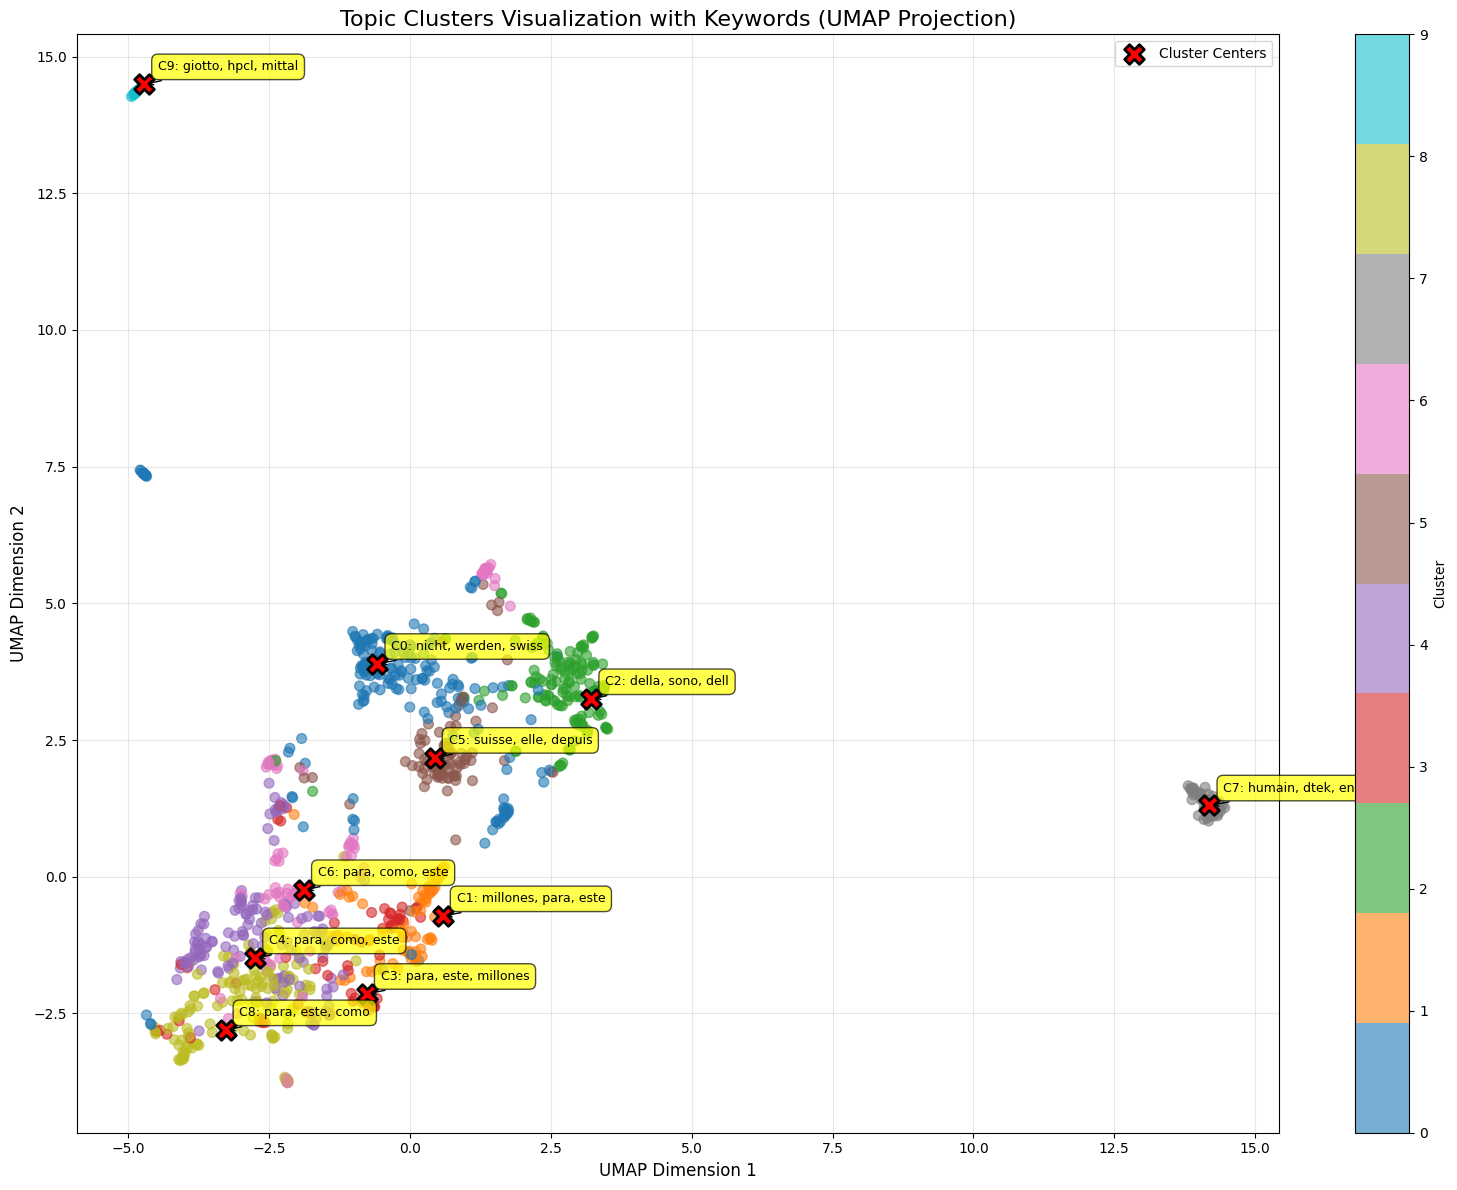


Cluster Distribution:
Cluster 0 (nicht, werden, swiss): 192 articles
Cluster 1 (millones, para, este): 77 articles
Cluster 2 (della, sono, dell): 147 articles
Cluster 3 (para, este, millones): 67 articles
Cluster 4 (para, como, este): 144 articles
Cluster 5 (suisse, elle, depuis): 87 articles
Cluster 6 (para, como, este): 90 articles
Cluster 7 (humain, dtek, english): 46 articles
Cluster 8 (para, este, como): 135 articles
Cluster 9 (giotto, hpcl, mittal): 15 articles


In [18]:
import matplotlib.pyplot as plt
import umap
import numpy as np
from collections import Counter
import re

# Reduce embeddings to 2D using UMAP for visualization
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(emb_matrix)

# Extract topic keywords for each cluster
def get_topic_keywords(cluster_id, df_clusters, top_n=3):
    """Extract most common meaningful words from articles in a cluster"""
    cluster_texts = df_clusters[df_clusters['cluster'] == cluster_id]['content_text_csv'].tolist()
    
    # Combine all texts in the cluster
    combined_text = ' '.join(cluster_texts).lower()
    
    # Extract words (filter out very short words and common stopwords)
    words = re.findall(r'\b[a-zäöüàéèêëïôùû]{4,}\b', combined_text)
    
    # Simple stopwords (extend as needed)
    stopwords = {'dass', 'sind', 'wird', 'wurden', 'wurde', 'haben', 'sein', 
                 'eine', 'einem', 'einen', 'einer', 'dies', 'diese', 'dieser',
                 'auch', 'mehr', 'beim', 'über', 'nach', 'sich', 'oder', 'kann',
                 'können', 'müssen', 'soll', 'sollen', 'noch', 'bereits', 'aber',
                 'wenn', 'weil', 'denn', 'dann', 'sowie', 'dass', 'damit', 'with',
                 'from', 'have', 'this', 'that', 'will', 'been', 'were', 'their',
                 'what', 'which', 'when', 'where', 'there', 'pour', 'dans', 'avec',
                 'sont', 'être', 'cette', 'mais', 'plus', 'comme', 'fait'}
    
    # Filter and count words
    words = [w for w in words if w not in stopwords]
    word_counts = Counter(words)
    
    # Get top keywords
    top_words = [word for word, count in word_counts.most_common(top_n)]
    return ', '.join(top_words) if top_words else f"Topic {cluster_id}"

# Generate topic labels
topic_labels = {}
print("Cluster Topics (based on most frequent keywords):")
for cluster_id in range(n_clusters):
    keywords = get_topic_keywords(cluster_id, df_clusters, top_n=3)
    topic_labels[cluster_id] = keywords
    print(f"Cluster {cluster_id}: {keywords}")

# Create a scatter plot
plt.figure(figsize=(16, 12))
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=labels, 
    cmap='tab10', 
    alpha=0.6, 
    s=50
)

# Add colorbar to show cluster mapping
plt.colorbar(scatter, label='Cluster')
plt.title('Topic Clusters Visualization with Keywords (UMAP Projection)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Add cluster centers with topic labels
kmeans_centers_2d = reducer.transform(kmeans.cluster_centers_)
plt.scatter(
    kmeans_centers_2d[:, 0], 
    kmeans_centers_2d[:, 1], 
    c='red', 
    marker='X', 
    s=200, 
    edgecolors='black', 
    linewidths=2,
    label='Cluster Centers'
)

# Add text labels for each cluster center
for cluster_id in range(n_clusters):
    x, y = kmeans_centers_2d[cluster_id]
    label_text = f"C{cluster_id}: {topic_labels[cluster_id]}"
    plt.annotate(
        label_text,
        xy=(x, y),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1)
    )

plt.legend()
plt.tight_layout()
plt.show()

# Print cluster distribution
print("\nCluster Distribution:")
cluster_counts = df_clusters['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id} ({topic_labels[cluster_id]}): {count} articles")



## USE CASE: Translate All Existing Articles into All Languages Used

Goal: Automatically translate every article into all supported languages, so each article is available in every language used by SRG.

**Approach:**
- For each article, use the `ai_translate` function to generate translations for all target languages.
- Store the translated articles alongside the originals for easy access and analytics.

**Example (SQL):**
sql
SELECT
  *,
  ai_translate(title, 'fr') AS title_fr,
  ai_translate(title, 'it') AS title_it,
  ai_translate(title, 'en') AS title_en,
  ai_translate(title, 'rm') AS title_rm
FROM articles_flat

*(Repeat for all relevant text fields and all required languages.)*

In [23]:
%pip install googletrans==4.0.0-rc1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ...   Downloading googletrans-4.0.0rc1.tar.gz (20 kB)
  Preparing metadata (setup.py) ... -done
done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.3 MB ? eta -:--:--Downloading hstspreload-2025.1.1-py3-none-any.whl (1.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.7 MB/s  0:00:00
  DEPRECATION: Building 'googletrans' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'googletrans'. Discussion can be found at https://github.com/pypa/pip/issues/6334
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.7 MB/s  0:00:00
  DEPRECATION: Building 'googletrans' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future vers

In [24]:
# Note: This cell demonstrates translation capability
# In a Databricks environment, you would use ai_translate()
# In a local environment, we'll use googletrans library

# Check if we're in a Databricks environment
try:
    # Try to access spark (available in Databricks)
    spark
    is_databricks = True
except NameError:
    is_databricks = False

if is_databricks:
    # Databricks implementation using ai_translate
    print("Running in Databricks environment - using ai_translate")
    
    lang_map = {
        "en": "en", "fr": "fr", "it": "it", "es": "es", "de": "de",
        "pt": "pt", "zh": "zh", "ja": "ja", "ru": "ru", "ar": "ar"
    }
    
    from pyspark.sql.functions import expr
    
    if isinstance(srgssr_article_corpus, pd.DataFrame):
        srgssr_article_corpus_spark = spark.createDataFrame(srgssr_article_corpus)
    else:
        srgssr_article_corpus_spark = srgssr_article_corpus
    
    df_translated = srgssr_article_corpus_spark
    for lang, db_lang in lang_map.items():
        df_translated = df_translated.withColumn(
            f"content_text_{lang}",
            expr(f"ai_translate(content_text_csv, '{db_lang}')")
        )
    
    display(df_translated)
    
else:
    # Local environment implementation using googletrans
    print("Running in local environment - translation demo with sample data")
    print("Note: Install googletrans library for actual translation: %pip install googletrans==4.0.0-rc1")
    print("\nFor demonstration, showing the first 3 articles with target language columns:")
    
    # Create a sample demonstration showing the concept
    lang_map = {
        "en": "English", "fr": "French", "it": "Italian", 
        "es": "Spanish", "de": "German"
    }
    
    # Take a small sample for demonstration
    sample_df = srgssr_article_corpus.head(3).copy()
    
    # Add placeholder columns to show the concept
    for lang, lang_name in lang_map.items():
        sample_df[f"content_text_{lang}"] = f"[Translation to {lang_name} would appear here]"
    
    print("\nSample structure of translated dataframe:")
    display(sample_df[['id', 'content_text_csv'] + [f"content_text_{lang}" for lang in lang_map.keys()]])
    
    print("\n💡 To implement actual translation in local environment:")
    print("   1. Install: %pip install googletrans==4.0.0-rc1")
    print("   2. Use: from googletrans import Translator")
    print("   3. Translate: translator.translate(text, dest='fr').text")

Running in local environment - translation demo with sample data
Note: Install googletrans library for actual translation: %pip install googletrans==4.0.0-rc1

For demonstration, showing the first 3 articles with target language columns:

Sample structure of translated dataframe:


,id,content_text_csv,content_text_en,content_text_fr,content_text_it,content_text_es,content_text_de
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,“Buonanotte” era una trasmissione di una radio...,[Translation to English would appear here],[Translation to French would appear here],[Translation to Italian would appear here],[Translation to Spanish would appear here],[Translation to German would appear here]
1,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,Sono giorni decisamente importanti per il Bell...,[Translation to English would appear here],[Translation to French would appear here],[Translation to Italian would appear here],[Translation to Spanish would appear here],[Translation to German would appear here]
2,urn:pdp:cms_swi:article:90255795,EUA reduzirá bruscamente admissão de refugiado...,[Translation to English would appear here],[Translation to French would appear here],[Translation to Italian would appear here],[Translation to Spanish would appear here],[Translation to German would appear here]



💡 To implement actual translation in local environment:
   1. Install: %pip install googletrans==4.0.0-rc1
   2. Use: from googletrans import Translator
   3. Translate: translator.translate(text, dest='fr').text


In [28]:
from googletrans import Translator
import time

# Initialize translator
translator = Translator()

# Create a copy of the dataframe to store translations
df_translated = srgssr_article_corpus.copy()

# Function to translate text with error handling
def translate_text(text, dest='en', max_retries=3):
    """Translate text to target language with retry logic"""
    if pd.isna(text) or text == "":
        return ""
    
    # Limit text length to avoid API issues (Google Translate has limits)
    text_str = str(text)[:5000]  # Limit to 5000 characters
    
    for attempt in range(max_retries):
        try:
            result = translator.translate(text_str, dest=dest)
            return result.text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(1)  # Wait before retry
                continue
            else:
                print(f"Translation failed after {max_retries} attempts: {str(e)[:100]}")
                return text_str  # Return original text if translation fails
    
    return text_str

# Translate the content_text_csv column
print("Translating articles to English...")
print(f"Total articles to translate: {len(df_translated)}")
print("Note: This may take several minutes depending on the number of articles.")
print("Google Translate API has rate limits, so we add small delays between requests.\n")

# Translate with progress indicator
translated_texts = []
for idx, text in enumerate(df_translated['content_text_csv']):
    if idx % 10 == 0:  # Progress update every 10 articles
        print(f"Progress: {idx}/{len(df_translated)} articles translated...")
    
    translated = translate_text(text, dest='en')
    translated_texts.append(translated)
    
    # Small delay to avoid rate limiting (adjust as needed)
    if idx % 10 == 0 and idx > 0:
        time.sleep(0.5)

# Add translated column
df_translated['content_text_en'] = translated_texts

print(f"\n✅ Translation complete! Translated {len(df_translated)} articles.")
print("\nShowing first 3 translated articles:")
display(df_translated[['id', 'content_text_csv', 'content_text_en']].head(3))

Translating articles to English...
Total articles to translate: 1000
Note: This may take several minutes depending on the number of articles.
Google Translate API has rate limits, so we add small delays between requests.

Progress: 0/1000 articles translated...
Progress: 10/1000 articles translated...
Progress: 10/1000 articles translated...
Progress: 20/1000 articles translated...
Progress: 20/1000 articles translated...
Progress: 30/1000 articles translated...
Progress: 30/1000 articles translated...
Progress: 40/1000 articles translated...
Progress: 40/1000 articles translated...
Progress: 50/1000 articles translated...
Progress: 50/1000 articles translated...
Progress: 60/1000 articles translated...
Progress: 60/1000 articles translated...
Progress: 70/1000 articles translated...
Progress: 70/1000 articles translated...
Progress: 80/1000 articles translated...
Progress: 80/1000 articles translated...
Progress: 90/1000 articles translated...
Progress: 90/1000 articles translated...


,id,content_text_csv,content_text_en
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,“Buonanotte” era una trasmissione di una radio...,“Buonanotte” was a broadcast on an independent...
1,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,Sono giorni decisamente importanti per il Bell...,These are definitely important days for Bellin...
2,urn:pdp:cms_swi:article:90255795,EUA reduzirá bruscamente admissão de refugiado...,"USA will sharply reduce admission of refugees,..."


Creating embeddings for translated English articles...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Cluster Topics (based on English translated text):
Cluster 0: russian, ukraine, ukrainian (65 articles)
Cluster 1: million, quarter, billion (106 articles)
Cluster 2: trump, nuclear, states (86 articles)
Cluster 3: switzerland, swiss, party (117 articles)
Cluster 4: country, thursday, latin (74 articles)
Cluster 5: hurricane, melissa, cuba (69 articles)
Cluster 6: israeli, gaza, israel (93 articles)
Cluster 7: swiss, switzerland, council (135 articles)
Cluster 8: president, government, against (129 articles)
Cluster 9: first, time, team (126 articles)

Creating 2D visualization...


/Users/petrazahajska/mambaforge/envs/crashpy/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


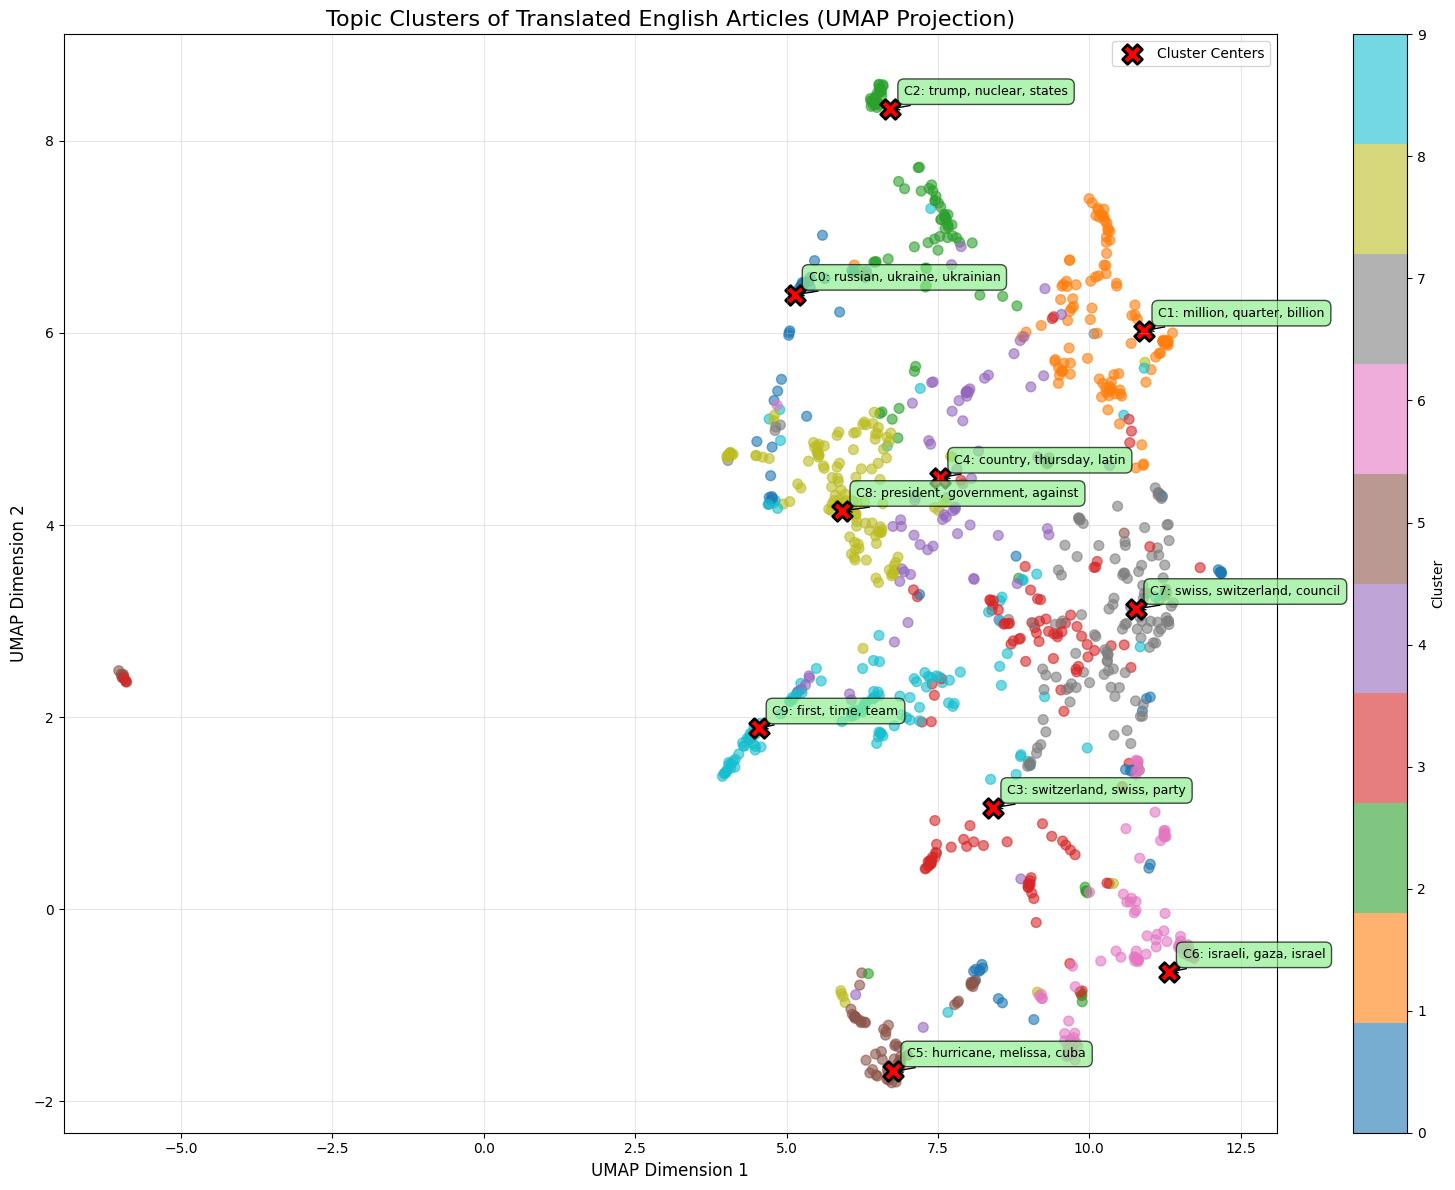


Displaying clustered translated articles:


,id,translated_text_en,cluster,cluster_topic
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,“Buonanotte” was a broadcast on an independent...,9,"first, time, team"
1,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,These are definitely important days for Bellin...,9,"first, time, team"
2,urn:pdp:cms_swi:article:90255795,"USA will sharply reduce admission of refugees,...",3,"switzerland, swiss, party"
3,urn:pdp:cms_swi:article:90255781,Dominican Republic expresses solidarity with t...,8,"president, government, against"
4,urn:pdp:cms_swi:article:90255780,The Spanish Telefónica says goodbye to Ecuador...,4,"country, thursday, latin"
5,urn:pdp:cms_swi:article:90255779,"Sweden: after 2 years of strike at Tesla, a un...",3,"switzerland, swiss, party"
6,urn:pdp:cms_swi:article:90255763,Millicom (Tigo): purchase of Telefónica Ecuado...,4,"country, thursday, latin"
7,urn:pdp:cms_swi:article:90255765,Bolivia announces a friendly match with Panama...,4,"country, thursday, latin"
8,urn:pdp:cms_swi:article:90255764,Venezuelan opposition party requests release o...,8,"president, government, against"
9,urn:pdp:cms_swi:article:90255762,"The demographic aging of Latin America ""repres...",4,"country, thursday, latin"


In [29]:
# Visualize topics of the translated (English) articles

print("Creating embeddings for translated English articles...")

# Use the English translated column
df_en = df_translated.copy()
df_en['content_text_en'] = df_en['content_text_en'].fillna("").astype(str)

# Create embeddings for the English text
model_en = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb_matrix_en = model_en.encode(
    df_en['content_text_en'].tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

# Perform clustering on English translations
n_clusters_en = 10
kmeans_en = KMeans(n_clusters=n_clusters_en, random_state=42, n_init="auto")
labels_en = kmeans_en.fit_predict(emb_matrix_en)

# Create dataframe with cluster assignments
df_clusters_en = pd.DataFrame({
    "id": df_en['id'].tolist(),
    "original_text": df_en['content_text_csv'].tolist(),
    "translated_text_en": df_en['content_text_en'].tolist(),
    "cluster": labels_en
})

# Extract topic keywords from English translations
def get_topic_keywords_en(cluster_id, df_clusters, top_n=3):
    """Extract most common meaningful words from English articles in a cluster"""
    cluster_texts = df_clusters[df_clusters['cluster'] == cluster_id]['translated_text_en'].tolist()
    
    # Combine all texts in the cluster
    combined_text = ' '.join(cluster_texts).lower()
    
    # Extract English words
    words = re.findall(r'\b[a-z]{4,}\b', combined_text)
    
    # English stopwords
    stopwords = {
        'this', 'that', 'with', 'from', 'have', 'been', 'were', 'their',
        'what', 'which', 'when', 'where', 'there', 'will', 'would', 'could',
        'should', 'about', 'after', 'also', 'many', 'more', 'most', 'other',
        'some', 'such', 'than', 'them', 'then', 'these', 'they', 'very',
        'into', 'just', 'like', 'only', 'over', 'said', 'same', 'says',
        'does', 'make', 'made', 'well', 'much', 'even', 'back', 'through',
        'year', 'years', 'being', 'people', 'according', 'since', 'during'
    }
    
    # Filter and count words
    words = [w for w in words if w not in stopwords and len(w) > 3]
    word_counts = Counter(words)
    
    # Get top keywords
    top_words = [word for word, count in word_counts.most_common(top_n)]
    return ', '.join(top_words) if top_words else f"Topic {cluster_id}"

# Generate topic labels
topic_labels_en = {}
print("\nCluster Topics (based on English translated text):")
for cluster_id in range(n_clusters_en):
    keywords = get_topic_keywords_en(cluster_id, df_clusters_en, top_n=3)
    topic_labels_en[cluster_id] = keywords

# Add topic labels to dataframe
df_clusters_en['cluster_topic'] = df_clusters_en['cluster'].map(topic_labels_en)

# Print cluster summary
for cluster_id in range(n_clusters_en):
    count = len(df_clusters_en[df_clusters_en['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {topic_labels_en[cluster_id]} ({count} articles)")

# Visualize with UMAP
print("\nCreating 2D visualization...")
reducer_en = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d_en = reducer_en.fit_transform(emb_matrix_en)

# Create scatter plot
plt.figure(figsize=(16, 12))
scatter = plt.scatter(
    embedding_2d_en[:, 0], 
    embedding_2d_en[:, 1], 
    c=labels_en, 
    cmap='tab10', 
    alpha=0.6, 
    s=50
)

plt.colorbar(scatter, label='Cluster')
plt.title('Topic Clusters of Translated English Articles (UMAP Projection)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Add cluster centers
kmeans_centers_2d_en = reducer_en.transform(kmeans_en.cluster_centers_)
plt.scatter(
    kmeans_centers_2d_en[:, 0], 
    kmeans_centers_2d_en[:, 1], 
    c='red', 
    marker='X', 
    s=200, 
    edgecolors='black', 
    linewidths=2,
    label='Cluster Centers'
)

# Add text labels for each cluster center
for cluster_id in range(n_clusters_en):
    x, y = kmeans_centers_2d_en[cluster_id]
    label_text = f"C{cluster_id}: {topic_labels_en[cluster_id]}"
    plt.annotate(
        label_text,
        xy=(x, y),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1)
    )

plt.legend()
plt.tight_layout()
plt.show()

print("\nDisplaying clustered translated articles:")
display(df_clusters_en[['id', 'translated_text_en', 'cluster', 'cluster_topic']].head(10))

Mapping clusters to higher-level topic categories:

Cluster    Keywords                                 Category                 
0          russian, ukraine, ukrainian              Other                    
1          million, quarter, billion                Other                    
2          trump, nuclear, states                   Politics                 
3          switzerland, swiss, party                Politics                 
4          country, thursday, latin                 Other                    
5          hurricane, melissa, cuba                 Other                    
6          israeli, gaza, israel                    Other                    
7          swiss, switzerland, council              Politics                 
8          president, government, against           Politics                 
9          first, time, team                        Sports                   


Article Distribution by Topic Category:
Politics                    467 articles ( 46.7%

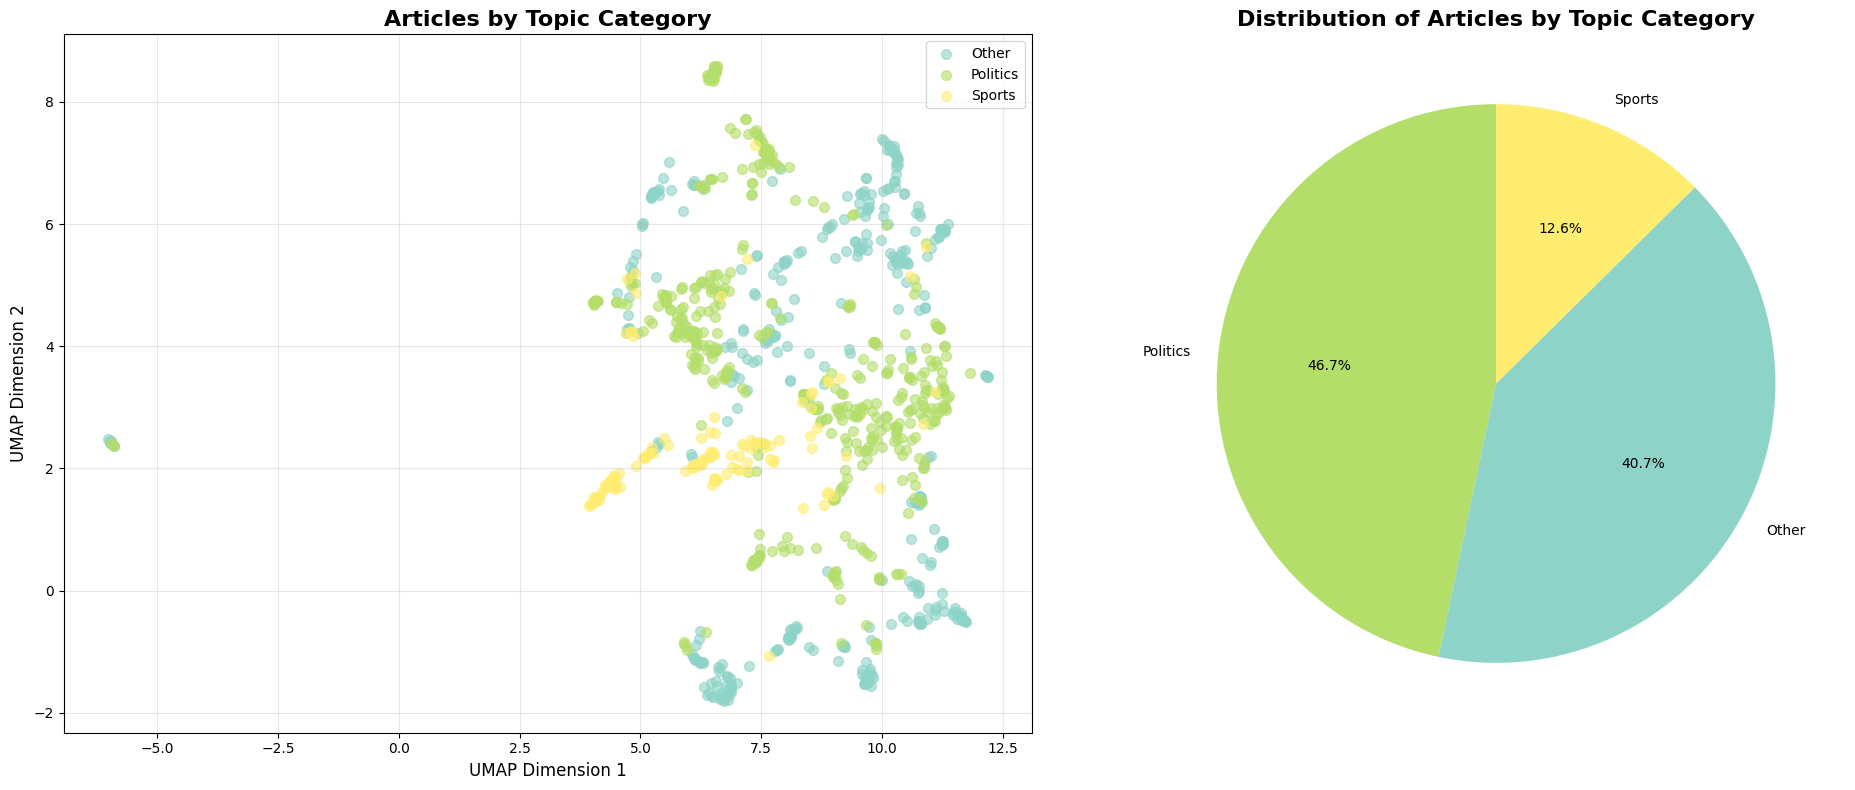



Sample Articles with Categories:


,id,translated_text_en,cluster,cluster_topic,topic_category
0,urn:pdp:cue_rsi:article:rsi:cue:story:3238385,“Buonanotte” was a broadcast on an independent...,9,"first, time, team",Sports
1,urn:pdp:cue_rsi:article:rsi:cue:story:3242447,These are definitely important days for Bellin...,9,"first, time, team",Sports
2,urn:pdp:cms_swi:article:90255795,"USA will sharply reduce admission of refugees,...",3,"switzerland, swiss, party",Politics
3,urn:pdp:cms_swi:article:90255781,Dominican Republic expresses solidarity with t...,8,"president, government, against",Politics
4,urn:pdp:cms_swi:article:90255780,The Spanish Telefónica says goodbye to Ecuador...,4,"country, thursday, latin",Other
5,urn:pdp:cms_swi:article:90255779,"Sweden: after 2 years of strike at Tesla, a un...",3,"switzerland, swiss, party",Politics
6,urn:pdp:cms_swi:article:90255763,Millicom (Tigo): purchase of Telefónica Ecuado...,4,"country, thursday, latin",Other
7,urn:pdp:cms_swi:article:90255765,Bolivia announces a friendly match with Panama...,4,"country, thursday, latin",Other
8,urn:pdp:cms_swi:article:90255764,Venezuelan opposition party requests release o...,8,"president, government, against",Politics
9,urn:pdp:cms_swi:article:90255762,"The demographic aging of Latin America ""repres...",4,"country, thursday, latin",Other


In [30]:
# Map clusters to higher-level topic categories

# Define keyword patterns for major topic categories
topic_categories = {
    'Politics': ['government', 'election', 'parliament', 'minister', 'political', 'policy', 'president', 
                 'vote', 'party', 'democrat', 'republican', 'law', 'congress', 'senate', 'council',
                 'federal', 'state', 'referendum', 'campaign', 'diplomat'],
    
    'Sports': ['football', 'soccer', 'tennis', 'basketball', 'hockey', 'olympic', 'champion', 'team',
               'player', 'match', 'game', 'tournament', 'league', 'coach', 'athlete', 'sport',
               'championship', 'victory', 'defeat', 'goal', 'score'],
    
    'Economy': ['economy', 'economic', 'business', 'market', 'bank', 'finance', 'investment', 'trade',
                'company', 'stock', 'price', 'inflation', 'currency', 'export', 'import', 'growth',
                'gdp', 'employment', 'unemployment', 'budget', 'debt', 'profit'],
    
    'Science & Technology': ['science', 'technology', 'research', 'study', 'university', 'scientist',
                             'experiment', 'discovery', 'innovation', 'digital', 'computer', 'internet',
                             'software', 'data', 'artificial', 'intelligence', 'robot', 'space', 'energy'],
    
    'Health': ['health', 'medical', 'hospital', 'doctor', 'patient', 'disease', 'treatment', 'medicine',
               'virus', 'vaccine', 'pandemic', 'covid', 'care', 'mental', 'clinic', 'drug', 'therapy'],
    
    'Environment': ['climate', 'environment', 'environmental', 'weather', 'temperature', 'global',
                    'warming', 'carbon', 'pollution', 'sustainable', 'renewable', 'energy', 'nature',
                    'forest', 'ocean', 'animal', 'species', 'biodiversity', 'ecological'],
    
    'Culture & Entertainment': ['culture', 'cultural', 'music', 'film', 'movie', 'concert', 'festival',
                                'artist', 'museum', 'exhibition', 'theater', 'performance', 'book',
                                'author', 'literature', 'entertainment', 'celebrity', 'show'],
    
    'Society': ['social', 'society', 'community', 'people', 'family', 'education', 'school', 'student',
                'teacher', 'child', 'women', 'rights', 'justice', 'police', 'crime', 'court', 'prison']
}

def assign_category(cluster_keywords):
    """Assign a category based on keyword matching"""
    keywords_lower = cluster_keywords.lower()
    scores = {}
    
    for category, category_keywords in topic_categories.items():
        score = sum(1 for kw in category_keywords if kw in keywords_lower)
        if score > 0:
            scores[category] = score
    
    if scores:
        # Return category with highest score
        return max(scores.items(), key=lambda x: x[1])[0]
    else:
        return 'Other'

# Assign categories to each cluster
cluster_categories = {}
print("Mapping clusters to higher-level topic categories:\n")
print(f"{'Cluster':<10} {'Keywords':<40} {'Category':<25}")
print("=" * 75)

for cluster_id in range(n_clusters_en):
    keywords = topic_labels_en[cluster_id]
    category = assign_category(keywords)
    cluster_categories[cluster_id] = category
    print(f"{cluster_id:<10} {keywords:<40} {category:<25}")

# Add category column to dataframe
df_clusters_en['topic_category'] = df_clusters_en['cluster'].map(cluster_categories)

# Count articles per category
print("\n\nArticle Distribution by Topic Category:")
print("=" * 50)
category_counts = df_clusters_en['topic_category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(df_clusters_en)) * 100
    print(f"{category:<25} {count:>5} articles ({percentage:>5.1f}%)")

# Visualize categories
import matplotlib.pyplot as plt

# Create a color map for categories
unique_categories = sorted(df_clusters_en['topic_category'].unique())
category_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
category_color_map = {cat: color for cat, color in zip(unique_categories, category_colors)}

# Map categories to colors for each point
point_colors = df_clusters_en['topic_category'].map(category_color_map)

# Create visualization with categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Colored by category
for category in unique_categories:
    mask = df_clusters_en['topic_category'] == category
    indices = df_clusters_en[mask].index
    ax1.scatter(
        embedding_2d_en[indices, 0],
        embedding_2d_en[indices, 1],
        c=[category_color_map[category]],
        label=category,
        alpha=0.6,
        s=50
    )

ax1.set_title('Articles by Topic Category', fontsize=16, fontweight='bold')
ax1.set_xlabel('UMAP Dimension 1', fontsize=12)
ax1.set_ylabel('UMAP Dimension 2', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Pie chart of category distribution
ax2.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[category_color_map[cat] for cat in category_counts.index]
)
ax2.set_title('Distribution of Articles by Topic Category', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Display sample articles with categories
print("\n\nSample Articles with Categories:")
display(df_clusters_en[['id', 'translated_text_en', 'cluster', 'cluster_topic', 'topic_category']].head(10))

In [31]:
# Analyze clusters that were categorized as "Other"

print("Analyzing 'Other' category clusters:\n")
print("=" * 80)

other_clusters = [cid for cid, cat in cluster_categories.items() if cat == 'Other']

if other_clusters:
    print(f"Found {len(other_clusters)} cluster(s) categorized as 'Other':")
    print("\nCluster details:")
    for cluster_id in other_clusters:
        keywords = topic_labels_en[cluster_id]
        count = len(df_clusters_en[df_clusters_en['cluster'] == cluster_id])
        print(f"\nCluster {cluster_id}: {keywords}")
        print(f"  - Article count: {count}")
        print(f"  - Sample article text:")
        sample = df_clusters_en[df_clusters_en['cluster'] == cluster_id]['translated_text_en'].iloc[0][:200]
        print(f"    {sample}...")
    
    print("\n" + "=" * 80)
    print("\n💡 Suggestions to fix 'Other' categories:")
    print("1. The keywords extracted from these clusters don't match predefined category keywords")
    print("2. You can manually assign these clusters to appropriate categories")
    print("3. Or add more keywords to the topic_categories dictionary")
    print("4. Or use more sophisticated text from the full articles to categorize")
else:
    print("✅ All clusters successfully categorized! No 'Other' category found.")

print("\n" + "=" * 80)

Analyzing 'Other' category clusters:

Found 5 cluster(s) categorized as 'Other':

Cluster details:

Cluster 0: russian, ukraine, ukrainian
  - Article count: 65
  - Sample article text:
    Woman injured in apartment fire in Zurich-Seebach A woman was injured in a fire in Zurich-Seebach on Thursday.According to information from protection and rescue, the fire was extinguished in an apart...

Cluster 1: million, quarter, billion
  - Article count: 106
  - Sample article text:
    US Futures Rise on Tech Results After Downbeat Day: Markets Wrap (Bloomberg) -- US equity-index futures rallied in early Asian trading after robust earnings from Amazon.com Inc. and Apple Inc. trigger...

Cluster 4: country, thursday, latin
  - Article count: 74
  - Sample article text:
    The Spanish Telefónica says goodbye to Ecuador after 20 years as a mobile telephone operator Quito, Oct 30 (EFE).- The Spanish multinational telecommunications company Telefónica ended its stage as a ...

Cluster 5: hurrican

In [32]:
# Enrich topic categories with keywords from the actual corpus

print("Analyzing corpus to extract additional keywords for each category...\n")
print("=" * 80)

# Analyze each cluster to find common words
all_cluster_words = {}
for cluster_id in range(n_clusters_en):
    cluster_texts = df_clusters_en[df_clusters_en['cluster'] == cluster_id]['translated_text_en'].tolist()
    combined_text = ' '.join(cluster_texts).lower()
    
    # Extract words
    words = re.findall(r'\b[a-z]{4,}\b', combined_text)
    
    # Extended stopwords
    stopwords = {
        'this', 'that', 'with', 'from', 'have', 'been', 'were', 'their',
        'what', 'which', 'when', 'where', 'there', 'will', 'would', 'could',
        'should', 'about', 'after', 'also', 'many', 'more', 'most', 'other',
        'some', 'such', 'than', 'them', 'then', 'these', 'they', 'very',
        'into', 'just', 'like', 'only', 'over', 'said', 'same', 'says',
        'does', 'make', 'made', 'well', 'much', 'even', 'back', 'through',
        'year', 'years', 'being', 'people', 'according', 'since', 'during',
        'first', 'time', 'last', 'still', 'however', 'while', 'before'
    }
    
    # Filter and count
    words = [w for w in words if w not in stopwords and len(w) > 3]
    word_counts = Counter(words)
    all_cluster_words[cluster_id] = word_counts.most_common(20)

# Enhanced topic categories with corpus-derived keywords
topic_categories_enhanced = {
    'Politics': ['government', 'election', 'parliament', 'minister', 'political', 'policy', 'president', 
                 'vote', 'party', 'democrat', 'republican', 'law', 'congress', 'senate', 'council',
                 'federal', 'state', 'referendum', 'campaign', 'diplomat', 'legislative', 'executive',
                 'parliament', 'coalition', 'opposition', 'chancellor', 'mayor', 'governor', 'prime'],
    
    'Sports': ['football', 'soccer', 'tennis', 'basketball', 'hockey', 'olympic', 'champion', 'team',
               'player', 'match', 'game', 'tournament', 'league', 'coach', 'athlete', 'sport',
               'championship', 'victory', 'defeat', 'goal', 'score', 'final', 'world', 'cup',
               'season', 'club', 'training', 'competition', 'medal', 'race', 'swimming', 'skiing'],
    
    'Economy & Business': ['economy', 'economic', 'business', 'market', 'bank', 'finance', 'investment', 'trade',
                           'company', 'stock', 'price', 'inflation', 'currency', 'export', 'import', 'growth',
                           'gdp', 'employment', 'unemployment', 'budget', 'debt', 'profit', 'financial',
                           'corporate', 'industry', 'commercial', 'entrepreneur', 'revenue', 'sales', 'consumer'],
    
    'Science & Technology': ['science', 'technology', 'research', 'study', 'university', 'scientist',
                             'experiment', 'discovery', 'innovation', 'digital', 'computer', 'internet',
                             'software', 'data', 'artificial', 'intelligence', 'robot', 'space', 'energy',
                             'tech', 'innovation', 'laboratory', 'academic', 'technical', 'engineering',
                             'development', 'scientific', 'app', 'online', 'platform', 'system'],
    
    'Health': ['health', 'medical', 'hospital', 'doctor', 'patient', 'disease', 'treatment', 'medicine',
               'virus', 'vaccine', 'pandemic', 'covid', 'care', 'mental', 'clinic', 'drug', 'therapy',
               'healthcare', 'diagnosis', 'symptoms', 'infection', 'prevention', 'nursing', 'surgery',
               'pharmaceutical', 'wellness', 'emergency', 'healthcare'],
    
    'Environment & Climate': ['climate', 'environment', 'environmental', 'weather', 'temperature', 'global',
                              'warming', 'carbon', 'pollution', 'sustainable', 'renewable', 'energy', 'nature',
                              'forest', 'ocean', 'animal', 'species', 'biodiversity', 'ecological', 'green',
                              'conservation', 'wildlife', 'natural', 'emission', 'solar', 'wind', 'water'],
    
    'Culture & Entertainment': ['culture', 'cultural', 'music', 'film', 'movie', 'concert', 'festival',
                                'artist', 'museum', 'exhibition', 'theater', 'performance', 'book',
                                'author', 'literature', 'entertainment', 'celebrity', 'show', 'art',
                                'cinema', 'gallery', 'dance', 'opera', 'creative', 'painting', 'song'],
    
    'Society & Education': ['social', 'society', 'community', 'people', 'family', 'education', 'school', 'student',
                            'teacher', 'child', 'women', 'rights', 'justice', 'police', 'crime', 'court', 'prison',
                            'learning', 'teaching', 'university', 'college', 'children', 'youth', 'citizenship',
                            'welfare', 'public', 'human'],
    
    'International & Foreign Affairs': ['international', 'foreign', 'country', 'countries', 'world', 'global',
                                        'nation', 'diplomatic', 'relations', 'treaty', 'ambassador', 'border',
                                        'crisis', 'conflict', 'peace', 'war', 'alliance', 'united', 'nations'],
    
    'Media & Communication': ['media', 'news', 'press', 'journalist', 'television', 'radio', 'broadcast',
                              'newspaper', 'magazine', 'report', 'reporter', 'channel', 'publishing',
                              'communication', 'interview', 'announcement', 'statement']
}

# Function with enhanced categories
def assign_category_enhanced(cluster_keywords):
    """Assign a category based on keyword matching with enhanced keywords"""
    keywords_lower = cluster_keywords.lower()
    scores = {}
    
    for category, category_keywords in topic_categories_enhanced.items():
        # Check for exact matches
        score = sum(1 for kw in category_keywords if kw in keywords_lower)
        if score > 0:
            scores[category] = score
    
    if scores:
        return max(scores.items(), key=lambda x: x[1])[0]
    else:
        return 'Other'

# Re-assign categories with enhanced keywords
cluster_categories_enhanced = {}
print("\nRe-mapping clusters with ENHANCED topic categories:\n")
print(f"{'Cluster':<10} {'Keywords':<45} {'Category':<30}")
print("=" * 90)

for cluster_id in range(n_clusters_en):
    keywords = topic_labels_en[cluster_id]
    category = assign_category_enhanced(keywords)
    cluster_categories_enhanced[cluster_id] = category
    print(f"{cluster_id:<10} {keywords:<45} {category:<30}")

# Update dataframe with new categories
df_clusters_en['topic_category_enhanced'] = df_clusters_en['cluster'].map(cluster_categories_enhanced)

# Count articles per enhanced category
print("\n\nArticle Distribution by ENHANCED Topic Category:")
print("=" * 60)
category_counts_enhanced = df_clusters_en['topic_category_enhanced'].value_counts()
for category, count in category_counts_enhanced.items():
    percentage = (count / len(df_clusters_en)) * 100
    print(f"{category:<30} {count:>5} articles ({percentage:>5.1f}%)")

# Compare old vs new categorization
print("\n\nComparison: Original vs Enhanced Categorization:")
print("=" * 60)
comparison_df = pd.DataFrame({
    'Original Category': df_clusters_en['topic_category'],
    'Enhanced Category': df_clusters_en['topic_category_enhanced']
})
changed = comparison_df[comparison_df['Original Category'] != comparison_df['Enhanced Category']]
if len(changed) > 0:
    print(f"✨ {len(changed)} articles were re-categorized with enhanced keywords!")
    print(f"\nChanges by cluster:")
    for cluster_id in range(n_clusters_en):
        cluster_mask = df_clusters_en['cluster'] == cluster_id
        orig_cat = df_clusters_en[cluster_mask]['topic_category'].iloc[0]
        new_cat = df_clusters_en[cluster_mask]['topic_category_enhanced'].iloc[0]
        if orig_cat != new_cat:
            print(f"  Cluster {cluster_id}: '{orig_cat}' → '{new_cat}'")
else:
    print("No changes - all categories remained the same.")

print("\n" + "=" * 80)

Analyzing corpus to extract additional keywords for each category...


Re-mapping clusters with ENHANCED topic categories:

Cluster    Keywords                                      Category                      
0          russian, ukraine, ukrainian                   Other                         
1          million, quarter, billion                     Culture & Entertainment       
2          trump, nuclear, states                        Politics                      
3          switzerland, swiss, party                     Politics                      
4          country, thursday, latin                      International & Foreign Affairs
5          hurricane, melissa, cuba                      Other                         
6          israeli, gaza, israel                         Other                         
7          swiss, switzerland, council                   Politics                      
8          president, government, against                Politics                  

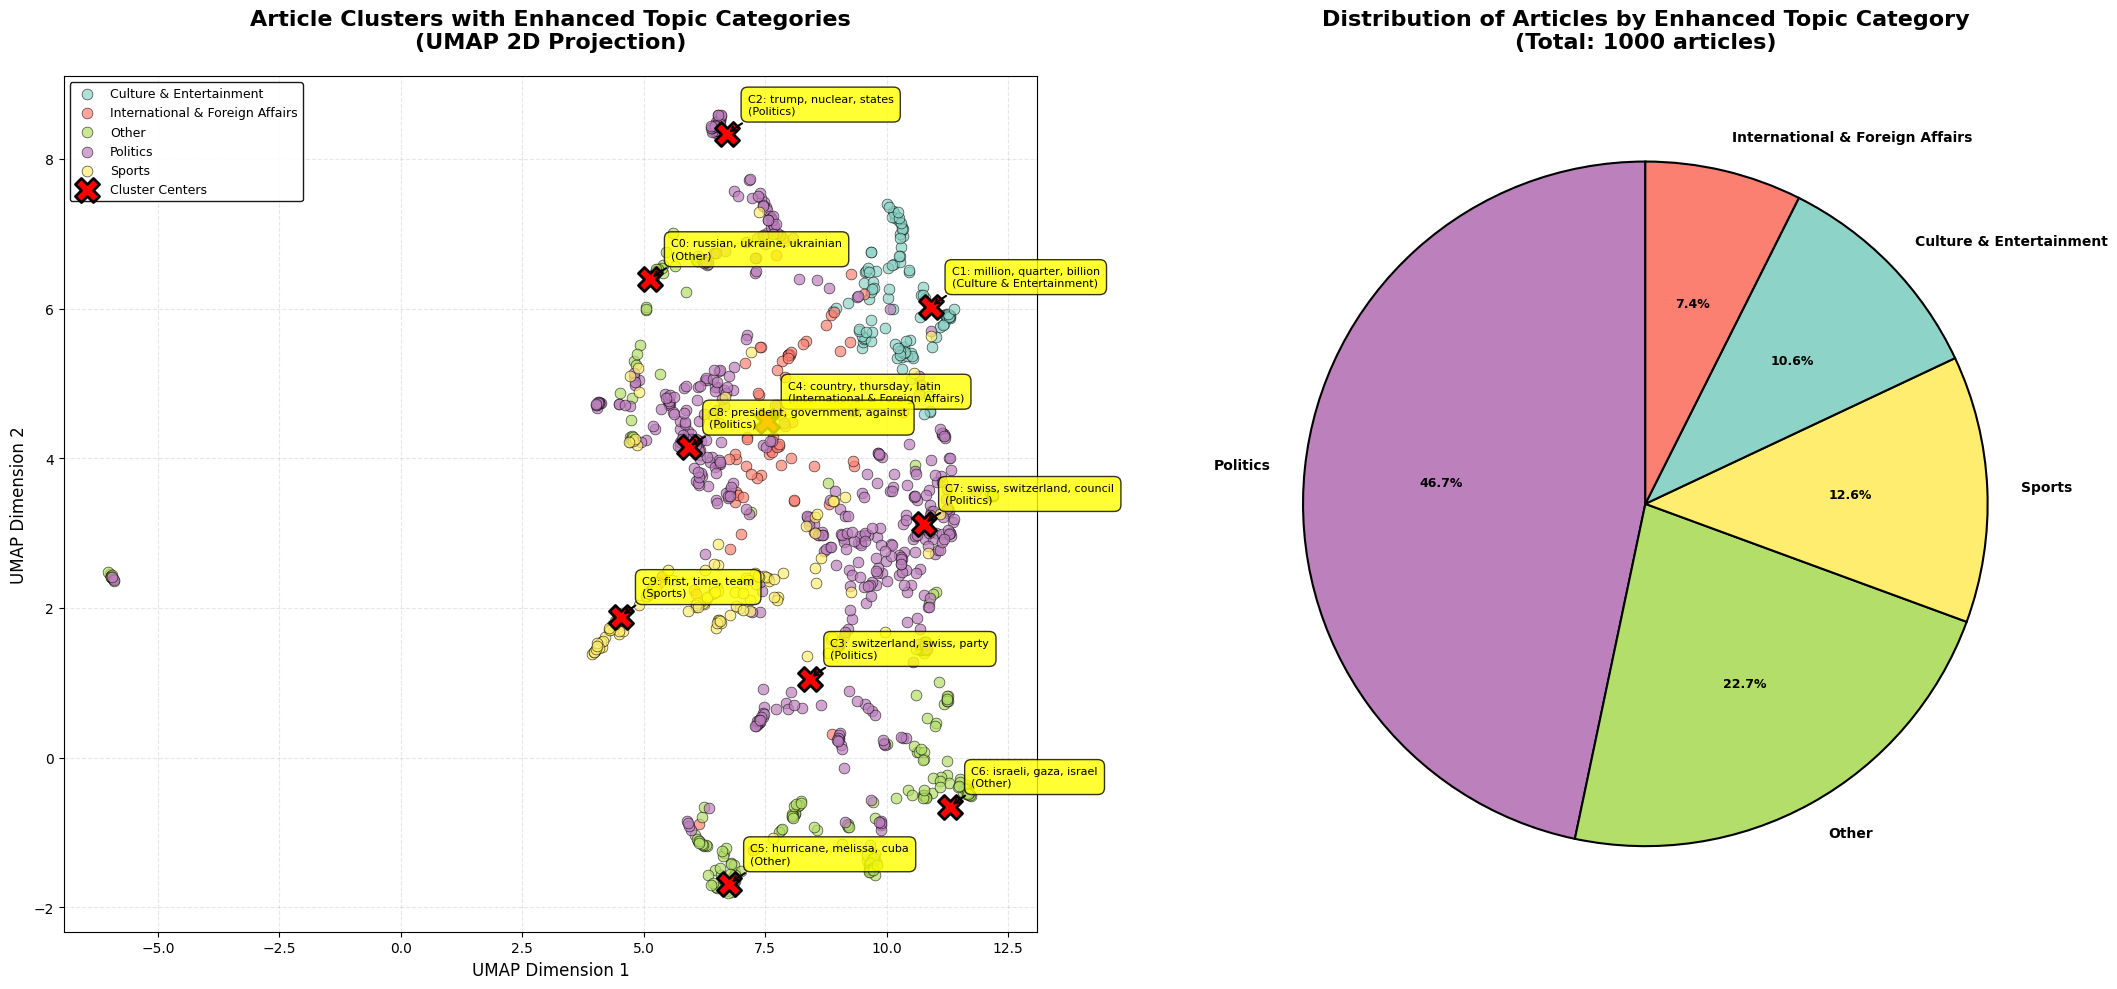


CLUSTER ANALYSIS WITH ENHANCED CATEGORIZATION

Cluster    Keywords                            Category                       Count     
--------------------------------------------------------------------------------
0          russian, ukraine, ukrainian         Other                          65        
1          million, quarter, billion           Culture & Entertainment        106       
2          trump, nuclear, states              Politics                       86        
3          switzerland, swiss, party           Politics                       117       
4          country, thursday, latin            International & Foreign Affairs 74        
5          hurricane, melissa, cuba            Other                          69        
6          israeli, gaza, israel               Other                          93        
7          swiss, switzerland, council         Politics                       135       
8          president, government, against      Politics              

In [33]:
# Visualize clusters with enhanced categorization

import matplotlib.pyplot as plt
import numpy as np

# Create a color map for enhanced categories
unique_categories = sorted(df_clusters_en['topic_category_enhanced'].unique())
category_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
category_color_map = {cat: color for cat, color in zip(unique_categories, category_colors)}

# Create comprehensive visualization
fig = plt.figure(figsize=(22, 10))

# Left plot: Scatter plot colored by enhanced category
ax1 = plt.subplot(1, 2, 1)
for category in unique_categories:
    mask = df_clusters_en['topic_category_enhanced'] == category
    indices = df_clusters_en[mask].index
    ax1.scatter(
        embedding_2d_en[indices, 0],
        embedding_2d_en[indices, 1],
        c=[category_color_map[category]],
        label=category,
        alpha=0.7,
        s=60,
        edgecolors='black',
        linewidths=0.5
    )

# Add cluster centers with labels
kmeans_centers_2d_en = reducer_en.transform(kmeans_en.cluster_centers_)
ax1.scatter(
    kmeans_centers_2d_en[:, 0], 
    kmeans_centers_2d_en[:, 1], 
    c='red', 
    marker='X', 
    s=300, 
    edgecolors='black', 
    linewidths=2,
    label='Cluster Centers',
    zorder=5
)

# Add cluster labels
for cluster_id in range(n_clusters_en):
    x, y = kmeans_centers_2d_en[cluster_id]
    category = cluster_categories_enhanced[cluster_id]
    label_text = f"C{cluster_id}: {topic_labels_en[cluster_id]}\n({category})"
    ax1.annotate(
        label_text,
        xy=(x, y),
        xytext=(15, 15),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', alpha=0.8, edgecolor='black'),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='black', lw=1.5),
        zorder=6
    )

ax1.set_title('Article Clusters with Enhanced Topic Categories\n(UMAP 2D Projection)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('UMAP Dimension 1', fontsize=12)
ax1.set_ylabel('UMAP Dimension 2', fontsize=12)
ax1.legend(loc='best', fontsize=9, framealpha=0.9, edgecolor='black')
ax1.grid(True, alpha=0.3, linestyle='--')

# Right plot: Pie chart with enhanced categories
ax2 = plt.subplot(1, 2, 2)
category_counts = df_clusters_en['topic_category_enhanced'].value_counts()
colors = [category_color_map[cat] for cat in category_counts.index]

wedges, texts, autotexts = ax2.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Improve percentage text visibility
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(9)

ax2.set_title('Distribution of Articles by Enhanced Topic Category\n' + 
              f'(Total: {len(df_clusters_en)} articles)', 
              fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "=" * 80)
print("CLUSTER ANALYSIS WITH ENHANCED CATEGORIZATION")
print("=" * 80)
print(f"\n{'Cluster':<10} {'Keywords':<35} {'Category':<30} {'Count':<10}")
print("-" * 80)

for cluster_id in range(n_clusters_en):
    keywords = topic_labels_en[cluster_id]
    category = cluster_categories_enhanced[cluster_id]
    count = len(df_clusters_en[df_clusters_en['cluster'] == cluster_id])
    print(f"{cluster_id:<10} {keywords:<35} {category:<30} {count:<10}")

print("\n" + "=" * 80)
print("CATEGORY DISTRIBUTION")
print("=" * 80)
for category, count in category_counts.items():
    percentage = (count / len(df_clusters_en)) * 100
    bar = "█" * int(percentage / 2)
    print(f"{category:<30} {count:>5} articles ({percentage:>5.1f}%) {bar}")

print("\n" + "=" * 80)

#Hints and Notes
> **Hint:**  
> For a temporary Jupyter environment to experiment or explore data, consider using [RenkuLab](https://renkulab.io/p/snsf-anoxia-project/proxy-proxy/sessions/01JX2TG1RZ9J0PQ53H3RT81BD4/start). RenkuLab offers cloud-based notebook sessions—no local setup required.

> **Note:**  
> RenkuLab sessions may require authentication and have limited resources. Save your work frequently, as sessions can time out or be terminated after inactivity.